## Stock Price Analysis

TODO:
- Create User input section
- use ffn (see old app for similar)
- Add linked histogram to select part of the graph and display the returns profile
- Link all widgets to allow updating of start and end dates and add new tickers

In [1]:
import datetime
import time

import ffn
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, display

In [2]:
%matplotlib inline

In [3]:
def get_data(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    """Get data from Yahoo Finance endpoint"""

    time.sleep(1)  # avoid spamming

    return ffn.get(ticker, start=start_date, end=end_date)


def convert_datetime_obj_to_string(date: datetime.datetime) -> str:
    return date.strftime("%Y-%m-%d")

In [4]:
start_date = widgets.DatePicker(
    description="Start Date",
    value=datetime.datetime.today() - datetime.timedelta(days=3 * 365),
)

end_date = widgets.DatePicker(description="End Date", value=datetime.datetime.today())

display(start_date, end_date)

DatePicker(value=datetime.datetime(2018, 10, 11, 20, 47, 57, 162952), description='Start Date')

DatePicker(value=datetime.datetime(2021, 10, 10, 20, 47, 57, 168408), description='End Date')

In [5]:
multiselect = widgets.SelectMultiple(
    options=["MSFT", "AAPL", "FB"],
    value=["AAPL"],
    description="Stocks",
    disabled=False,
)

button = widgets.Button(
    description="Get data for selected stocks",
    disabled=False,
    button_style="info",  # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click me",
    layout=widgets.Layout(width="auto", height="30px"),
)

display(widgets.HBox([button, multiselect]))

In [6]:
ticker = "AAPL, MSFT"
data = get_data(
    ticker,
    convert_datetime_obj_to_string(start_date.value),
    convert_datetime_obj_to_string(end_date.value),
)

In [7]:
display(HTML(f"<h3>{ticker}</h3>"))

In [8]:
stock_summary_tab = widgets.VBox([])


histogram_tab = widgets.VBox([])

daily_stock_price_output = widgets.Output()
with daily_stock_price_output:
    display(data)

matrix_tab = widgets.VBox([widgets.HBox([daily_stock_price_output])])

output_box = widgets.Tab(
    children=[matrix_tab, stock_summary_tab, histogram_tab],
    layout=widgets.Layout(height="398px"),
)

In [9]:
tab_names = ["Daily Stock Price", "Stock Summary", "Histogram"]

for i, title in enumerate(tab_names):
    output_box.set_title(i, title)

output_box

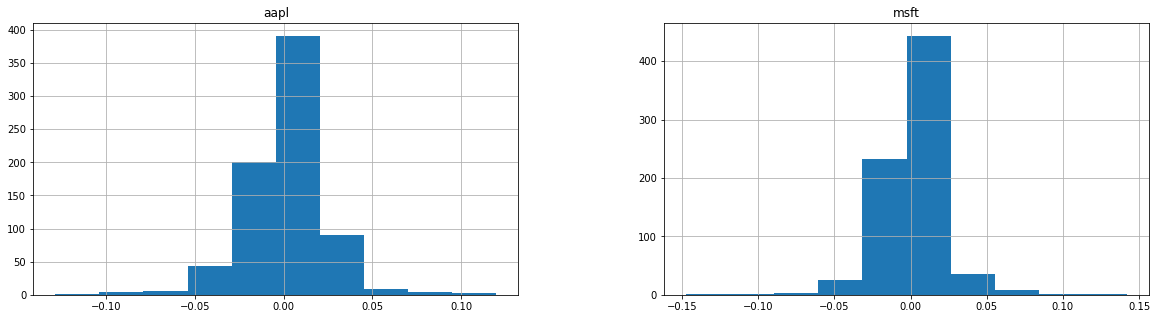

In [10]:
returns = data.to_returns().dropna()
ax = returns.hist(figsize=(20, 5))
plt.show()

In [11]:
stats = data.calc_stats()

stats.display()

Stat                 aapl        msft
-------------------  ----------  ----------
Start                2018-10-11  2018-10-11
End                  2021-10-08  2021-10-08
Risk-free rate       0.00%       0.00%

Total Return         175.12%     188.61%
Daily Sharpe         1.13        1.28
Daily Sortino        1.85        2.11
CAGR                 40.24%      42.50%
Max Drawdown         -35.94%     -28.04%
Calmar Ratio         1.12        1.52

MTD                  0.99%       4.59%
3m                   -0.09%      6.49%
6m                   9.97%       16.92%
YTD                  8.20%       33.43%
1Y                   25.09%      41.30%
3Y (ann.)            40.24%      42.50%
5Y (ann.)            -           -
10Y (ann.)           -           -
Since Incep. (ann.)  40.24%      42.50%

Daily Sharpe         1.13        1.28
Daily Sortino        1.85        2.11
Daily Mean (ann.)    40.18%      40.49%
Daily Vol (ann.)     35.45%      31.60%
Daily Skew           -0.14       -0.05
Daily Kur

/Users/jnes/miniconda3/envs/e4ds/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/Users/jnes/miniconda3/envs/e4ds/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


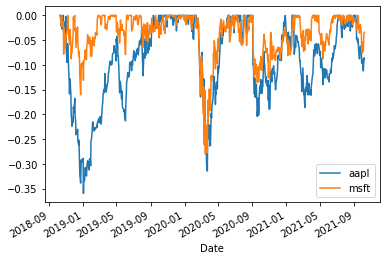

In [12]:
ax = stats.prices.to_drawdown_series().plot()
plt.show()

/Users/jnes/miniconda3/envs/e4ds/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/Users/jnes/miniconda3/envs/e4ds/lib/python3.9/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


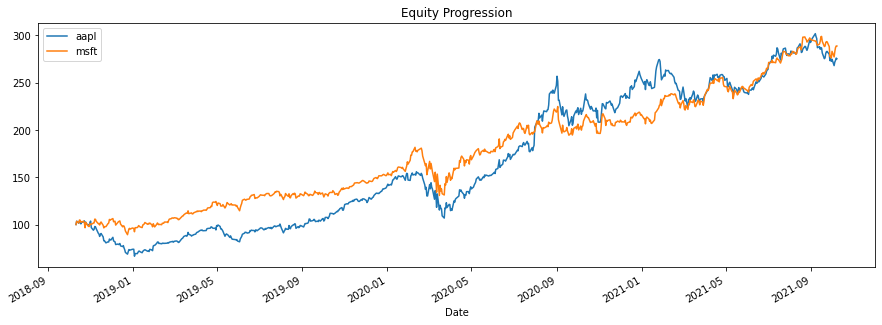

In [13]:
data.calc_stats().plot()
plt.show()

Created by [EngineeringforDataScience](https://engineeringfordatascience.com/) ⚒️ | [Source Code](https://github.com/julian-west/e4ds-snippets/tree/voila/jupyter/voila/part1)